Data exploratoin, plot scatter plots to view

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the data
file_path = "/explore/nobackup/people/spotter5/new_combustion/2025-08-13_LC_FISL_Original_combustionModelPredictors.csv"
df = pd.read_csv(file_path)

old = pd.read_csv("/explore/nobackup/people/spotter5/new_combustion/Combustion_SynthesisData_05042018_XJW.csv")

# --- EDITED SECTION START ---

# 1. Select only the necessary columns from the 'old' dataframe
old_subset = old[['id', 'burn.depth']].copy()

# 2. Handle potential duplicates in both dataframes before merging
print(f"Original shape of df: {df.shape}")
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of df after dropping duplicates: {df.shape}")

print(f"\nOriginal shape of old_subset: {old_subset.shape}")
old_subset.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of old_subset after dropping duplicates: {old_subset.shape}")


# 3. Print the number of missing 'burn.depth' values before the operation
print(f"\nMissing 'burn.depth' values in df before update: {df['burn.depth'].isna().sum()}")

# 4. Set 'id' as the index for both DataFrames.
# This now works because we've removed the duplicate 'id's.
df.set_index('id', inplace=True)
old_subset.set_index('id', inplace=True)

# 5. Use combine_first to fill NA values in df['burn.depth']
# It takes a value from 'df' if it exists, otherwise it looks for a
# corresponding value (by index 'id') in 'old_subset'.
df['burn.depth'] = df['burn.depth'].combine_first(old_subset['burn.depth'])

# 6. Reset the index to turn 'id' back into a column
df.reset_index(inplace=True)

# 7. Print the number of missing values after the operation to confirm the fix
print(f"Missing 'burn.depth' values in df after update:  {df['burn.depth'].isna().sum()}")

# --- EDITED SECTION END ---

# Drop rows with any missing values
df_clean = df.dropna()

# Columns to exclude from predictor variables
exclude_columns = [
    'above.carbon.combusted', 
    'below.ground.carbon.combusted', 
    #'rdnbr_old',
    'burn.depth',
    'burn_year', 
    'project.name', 
    'latitude', 
    'longitude', 
    'Date',
    'id'
    'CNA_MAR',
    'fireYr',
    'lat',
    'lon',
     'project_name'

]

# Get list of independent (predictor) variables
independent_vars = [col for col in df_clean.columns if col not in exclude_columns]

# Define output directory
output_dir = os.path.expanduser("/explore/nobackup/people/spotter5/new_combustion/scatter_plots/all_data/depth")
os.makedirs(output_dir, exist_ok=True)

# Generate and save scatter plots
for var in independent_vars:
    plt.figure(figsize=(6, 4))
    plt.scatter(df_clean[var], df_clean['burn.depth'], alpha=0.6)
    plt.xlabel(var)
    plt.ylabel('burn.depth')
    plt.title(f'{var} vs above.carbon.combusted')
    plt.tight_layout()
    output_file = os.path.join(output_dir, f"{var}_vs_above_carbon_combusted.png")
    plt.savefig(output_file)
    plt.close()


Original shape of df: (1877, 88)
Shape of df after dropping duplicates: (1877, 88)

Original shape of old_subset: (1172, 2)
Shape of old_subset after dropping duplicates: (1171, 2)

Missing 'burn.depth' values in df before update: 1011
Missing 'burn.depth' values in df after update:  107


Recursive feature elimination 

Original shape of df: (1877, 88)
Shape of df after dropping duplicates: (1877, 88)

Original shape of old_subset: (1172, 2)
Shape of old_subset after dropping duplicates: (1171, 2)

Missing 'burn.depth' values in df before update: 1011
Missing 'burn.depth' values in df after update:  107


/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/spotter5/.conda/envs/xgboost_gpu/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecat

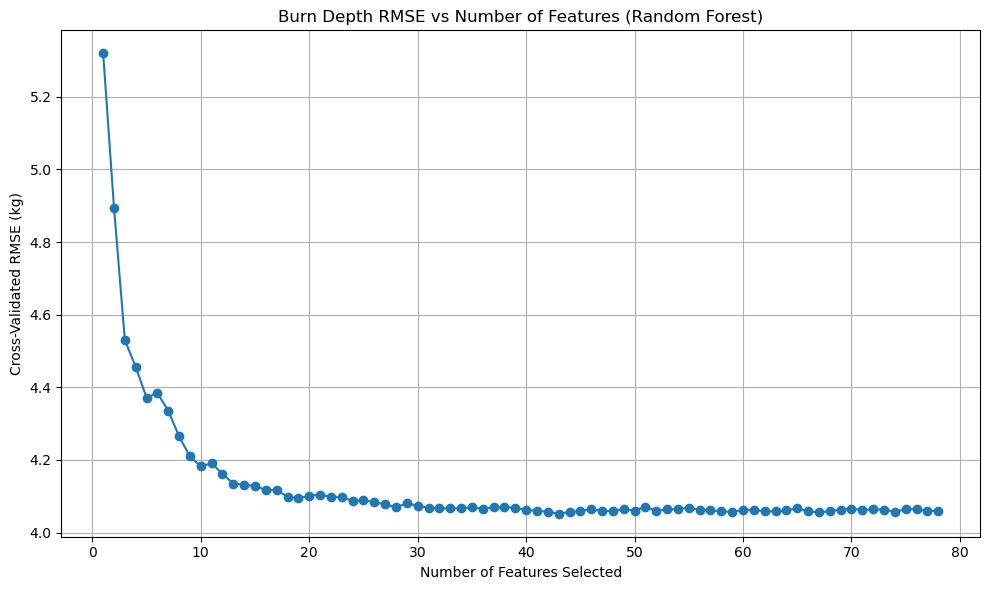

Optimal number of features: 1
Selected features: ['CNA_DD5_5_8']

Top 10 most important features (full model):
1. CNA_Rad_5_8 (importance: 0.1294)
2. Tree.cover (importance: 0.0345)
3. twi (importance: 0.0338)
4. CNA_DD5_5_8 (importance: 0.0313)
5. Silt_30 (importance: 0.0311)
6. CNA_EXT (importance: 0.0288)
7. CNA_DD_18_5_8 (importance: 0.0281)
8. greenness (importance: 0.0265)
9. brightness (importance: 0.0262)
10. CNA_FFP (importance: 0.0240)
11. pH_30 (importance: 0.0210)
12. ruggedness (importance: 0.0204)
13. GRSH (importance: 0.0200)
14. Sand_30 (importance: 0.0198)
15. rbr (importance: 0.0195)
16. Clay_30 (importance: 0.0194)
17. NDII (importance: 0.0193)
18. HLI (importance: 0.0177)
19. dNBR (importance: 0.0173)
20. WS (importance: 0.0169)


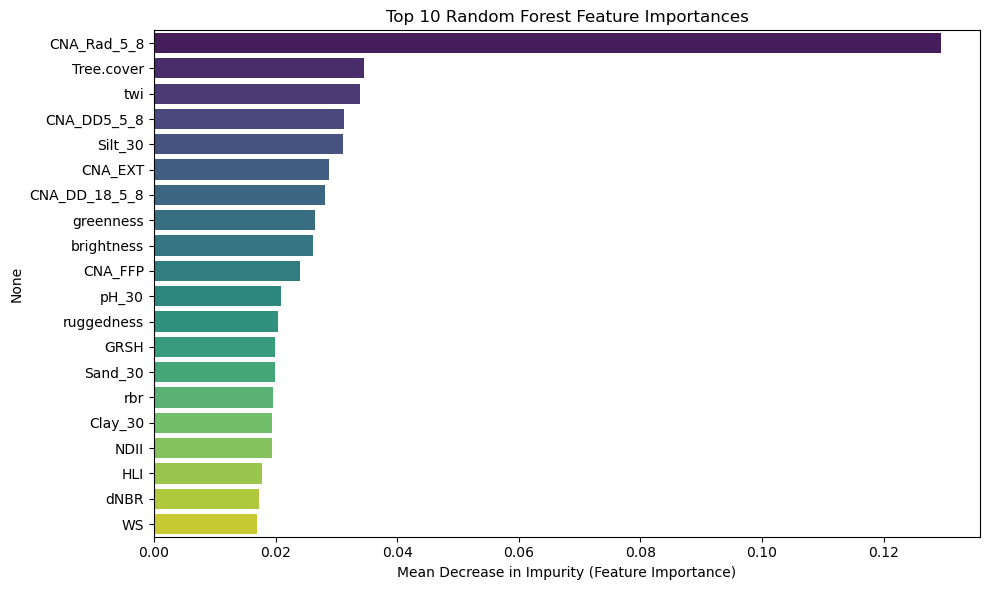

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

# 1. Load and clean data
df = pd.read_csv("/explore/nobackup/people/spotter5/new_combustion/2025-08-13_LC_FISL_Original_combustionModelPredictors.csv")

old = pd.read_csv("/explore/nobackup/people/spotter5/new_combustion/Combustion_SynthesisData_05042018_XJW.csv")

# --- EDITED SECTION START ---

# 1. Select only the necessary columns from the 'old' dataframe
old_subset = old[['id', 'burn.depth']].copy()

# 2. Handle potential duplicates in both dataframes before merging
print(f"Original shape of df: {df.shape}")
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of df after dropping duplicates: {df.shape}")

print(f"\nOriginal shape of old_subset: {old_subset.shape}")
old_subset.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of old_subset after dropping duplicates: {old_subset.shape}")


# 3. Print the number of missing 'burn.depth' values before the operation
print(f"\nMissing 'burn.depth' values in df before update: {df['burn.depth'].isna().sum()}")

# 4. Set 'id' as the index for both DataFrames.
# This now works because we've removed the duplicate 'id's.
df.set_index('id', inplace=True)
old_subset.set_index('id', inplace=True)

# 5. Use combine_first to fill NA values in df['burn.depth']
# It takes a value from 'df' if it exists, otherwise it looks for a
# corresponding value (by index 'id') in 'old_subset'.
df['burn.depth'] = df['burn.depth'].combine_first(old_subset['burn.depth'])

# 6. Reset the index to turn 'id' back into a column
df.reset_index(inplace=True)

# 7. Print the number of missing values after the operation to confirm the fix
print(f"Missing 'burn.depth' values in df after update:  {df['burn.depth'].isna().sum()}")

# --- EDITED SECTION END ---


out_path = "/explore/nobackup/people/spotter5/new_combustion/all_data"
os.makedirs(out_path, exist_ok = True)

# 2. Exclude columns not relevant for modeling
exclude_columns = [
    'below.ground.carbon.combusted',
    'above.carbon.combusted',
    #'burn.depth',
    'burn_year',
    #'rdnbr_old',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
     # 'fireYr',
    # 'lat',
    # 'lon',
    # 'project_name'
]

# 3. Drop excluded columns and NaNs
df_clean = df.drop(columns=exclude_columns).dropna()

# 4. Define target (y) and predictors (X) — exclude y from X
y = df_clean['burn.depth']# / 1000  # g to kg
X = df_clean.drop(columns=['burn.depth'])

# 5. Set up scorer and model
rmse_scorer = make_scorer(mean_squared_error, squared=False)
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 6. Run RFECV
rfecv = RFECV(estimator=rf, step=1, cv=cv, scoring=rmse_scorer, n_jobs=-1)
rfecv.fit(X, y)

# 7. Plot CV RMSE vs number of features
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
    rfecv.cv_results_['mean_test_score'],
    marker='o'
)
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validated RMSE (kg)")
plt.title("Burn Depth RMSE vs Number of Features (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_path, "depth_rfe.png"))
plt.show()

# 8. Print optimal features
selected_features = list(X.columns[rfecv.support_])
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", selected_features)


# 9. Train full model to get top 10 global feature importances
full_rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
full_rf.fit(X, y)
full_importances = pd.Series(full_rf.feature_importances_, index=X.columns)
top_10_features = full_importances.sort_values(ascending=False).head(20)

# Print top 10
print("\nTop 10 most important features (full model):")
for i, (name, value) in enumerate(top_10_features.items(), 1):
    print(f"{i}. {name} (importance: {value:.4f})")

# 10. Create a new DataFrame with only the top 10 features
top_10_df_above = X[top_10_features.index].copy()

# 11. Plot top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")
plt.xlabel("Mean Decrease in Impurity (Feature Importance)")
plt.title("Top 10 Random Forest Feature Importances")
plt.tight_layout()
plt.savefig(os.path.join(out_path, "depth_rf_importance.png"))
plt.show()


SHAP values

In [3]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import os # Import the os module

# Define the output path and create the directory
out_path = "/explore/nobackup/people/spotter5/new_combustion/all_data"
os.makedirs(out_path, exist_ok = True)

# 1. Load and clean data
df = pd.read_csv("/explore/nobackup/people/spotter5/new_combustion/2025-08-13_LC_FISL_Original_combustionModelPredictors.csv")

old = pd.read_csv("/explore/nobackup/people/spotter5/new_combustion/Combustion_SynthesisData_05042018_XJW.csv")

# --- EDITED SECTION START ---

# 1. Select only the necessary columns from the 'old' dataframe
old_subset = old[['id', 'burn.depth']].copy()

# 2. Handle potential duplicates in both dataframes before merging
print(f"Original shape of df: {df.shape}")
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of df after dropping duplicates: {df.shape}")

print(f"\nOriginal shape of old_subset: {old_subset.shape}")
old_subset.drop_duplicates(subset='id', keep='first', inplace=True)
print(f"Shape of old_subset after dropping duplicates: {old_subset.shape}")


# 3. Print the number of missing 'burn.depth' values before the operation
print(f"\nMissing 'burn.depth' values in df before update: {df['burn.depth'].isna().sum()}")

# 4. Set 'id' as the index for both DataFrames.
# This now works because we've removed the duplicate 'id's.
df.set_index('id', inplace=True)
old_subset.set_index('id', inplace=True)

# 5. Use combine_first to fill NA values in df['burn.depth']
# It takes a value from 'df' if it exists, otherwise it looks for a
# corresponding value (by index 'id') in 'old_subset'.
df['burn.depth'] = df['burn.depth'].combine_first(old_subset['burn.depth'])

# 6. Reset the index to turn 'id' back into a column
df.reset_index(inplace=True)

# 7. Print the number of missing values after the operation to confirm the fix
print(f"Missing 'burn.depth' values in df after update:  {df['burn.depth'].isna().sum()}")

# --- EDITED SECTION END ---

exclude_columns = [
    'below.ground.carbon.combusted',
    'above.carbon.combusted',
    #'burn.depth',
    #'rdnbr_old',
    'burn_year',
    'project.name',
    'latitude',
    'longitude',
    'Date',
    'id',
    'CNA_MAR'
    #  'fireYr',
    # 'lat',
    # 'lon',
    # 'project_name'
]
df_clean = df.drop(columns=exclude_columns).dropna()

# 2. Split into X and y
y = df_clean['burn.depth']# / 1000  # g to kg
X = df_clean.drop(columns=['burn.depth'])

# 3. Fit Random Forest model
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 4. Initialize SHAP explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

# 5. SHAP summary plot (bar for global importance) and save
print("Generating and saving SHAP bar plot...")
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.savefig(os.path.join(out_path, 'depth_shap_summary_bar.png'), bbox_inches='tight')
plt.close() # Close the plot to free memory

# 6. SHAP summary plot (beeswarm for interaction direction) and save
print("Generating and saving SHAP beeswarm plot...")
shap.summary_plot(shap_values, X, show=False)
plt.savefig(os.path.join(out_path, 'depth_shap_summary_beeswarm.png'), bbox_inches='tight')
plt.close() # Close the plot to free memory

print(f"Plots saved successfully to: {out_path}")

Original shape of df: (1877, 88)
Shape of df after dropping duplicates: (1877, 88)

Original shape of old_subset: (1172, 2)
Shape of old_subset after dropping duplicates: (1171, 2)

Missing 'burn.depth' values in df before update: 1011
Missing 'burn.depth' values in df after update:  107
Generating and saving SHAP bar plot...
Generating and saving SHAP beeswarm plot...
Plots saved successfully to: /explore/nobackup/people/spotter5/new_combustion/all_data


Run 10-fold CV above RF

In [4]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

# Define 10-fold CV and Random Forest model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Perform 10-fold cross-validated predictions
y_cv_pred = cross_val_predict(model, top_10_df_above, y, cv=cv)

# Calculate metrics
cv_rmse = mean_squared_error(y, y_cv_pred, squared=False)
cv_r2 = r2_score(y, y_cv_pred)

cv_rmse, cv_r2


(4.045586260342575, 0.5963153985280489)

LOOCV

In [5]:
from sklearn.model_selection import cross_val_predict, LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Use Leave-One-Out Cross-Validation
cv = LeaveOneOut()
model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

# Perform LOOCV predictions
y_cv_pred = cross_val_predict(model, top_10_df_above, y, cv=cv)

# Compute metrics
cv_rmse = mean_squared_error(y, y_cv_pred, squared=False)
cv_r2 = r2_score(y, y_cv_pred)

print(f"LOOCV RMSE: {cv_rmse:.3f} kg")
print(f"LOOCV R²: {cv_r2:.3f}")


LOOCV RMSE: 4.001 kg
LOOCV R²: 0.605


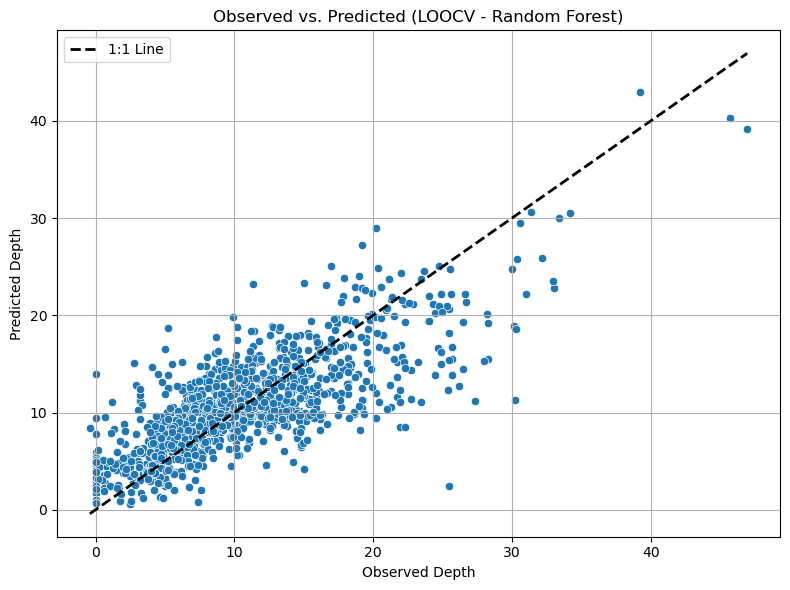

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Observed vs. Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_cv_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, label='1:1 Line')
plt.xlabel("Observed Depth")
plt.ylabel("Predicted Depth")
plt.title("Observed vs. Predicted (LOOCV - Random Forest)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_path, "depth_ob_pred.png"))
plt.show()

10-fold CV Above XGBoost

In [7]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


from xgboost import XGBRegressor
from sklearn.model_selection import KFold, GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'n_estimators': [500]
}

# Initialize model and CV
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit
grid_search.fit(top_10_df_above, y)

# Best result
best_rmse = -grid_search.best_score_
best_params = grid_search.best_params_

print(f"Best RMSE: {best_rmse:.3f}")
print("Best Parameters:", best_params)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

# 10-fold CV for R² using the best model
cv = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores = cross_val_score(
    grid_search.best_estimator_,
    top_10_df_above,
    y,
    scoring='r2',
    cv=cv,
    n_jobs=-1
)

print(f"10-Fold CV R²: {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")


Best RMSE: 3.979
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}
10-Fold CV R²: 0.582 ± 0.101
